In [ ]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
!unzip -uq "/content/drive/My Drive/images/hornets.zip" -d "/content/drive/My Drive/images"

In [ ]:

import io
import requests
from PIL import Image
from torchvision import models, transforms, datasets
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb
import torch

import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
cd /content/drive/My Drive/images/hornets

/content/drive/My Drive/images/hornets


In [ ]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      
                                      transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

training_dataset = datasets.ImageFolder('imgs_train', transform=transform_train)
validation_dataset = datasets.ImageFolder('imgs_test', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)

In [ ]:
print(len(training_dataset))
print(len(validation_dataset))

2886
720


In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [ ]:
classes = ('absence', 'presence')

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

In [ ]:

model = models.resnet18(pretrained=True)

In [ ]:
print(model)

for param in model.layer4:
    param.requires_grad = False

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.nn as nn

#n_inputs = model.classifier[6].in_features
#last_layer = nn.Linear(n_inputs, len(classes))
#model.classifier[6] = last_layer
#model.to(device)
#print(model.classifier[6].out_features)
#print(model)

finalconv_name = 'layer4'
n_inputs = model.fc.in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.fc = last_layer
model.to(device)
print(model.fc.out_features)
print(model)

2
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.0113, acc 0.9130 
validation loss: 0.0609, validation acc 0.6347 
epoch : 2
training loss: 0.0058, acc 0.9602 
validation loss: 0.0662, validation acc 0.6153 
epoch : 3
training loss: 0.0050, acc 0.9660 
validation loss: 0.0765, validation acc 0.6944 
epoch : 4
training loss: 0.0045, acc 0.9712 
validation loss: 0.0790, validation acc 0.6819 
epoch : 5
training loss: 0.0036, acc 0.9744 
validation loss: 0.0804, validation acc 0.6875 
epoch : 6
training loss: 0.0045, acc 0.9740 
validation loss: 0.0747, validation acc 0.7153 
epoch : 7
training loss: 0.0035, acc 0.9761 
validation loss: 0.0811, validation acc 0.6972 
epoch : 8
training loss: 0.0030, acc 0.9820 
validation loss: 0.0816, validation acc 0.6625 
epoch : 9
training loss: 0.0026, acc 0.9830 
validation loss: 0.0783, validation acc 0.7208 
epoch : 10
training loss: 0.0024, acc 0.9861 
validation loss: 0.0856, validation acc 0.7139 


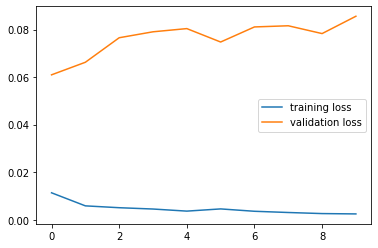

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

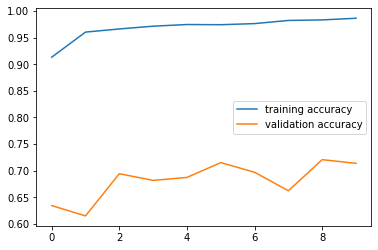

In [ ]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [ ]:
features_blobs = []
def hook_feature(module, input, output):
  features_blobs.append(output.data.cpu().numpy())

model._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())
#
def returnCAM(feature_conv, weight_softmax, class_idx):
  # generate the class activation maps upsample to 256x256
  size_upsample = (256, 256)
  bz, nc, h, w = feature_conv.shape
  output_cam = []
  for idx in class_idx:
      cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
      cam = cam.reshape(h, w)
      cam = cam - np.min(cam)
      cam_img = cam / np.max(cam)
      cam_img = np.uint8(255 * cam_img)
      output_cam.append(cv2.resize(cam_img, size_upsample))
  return output_cam

    




In [ ]:
cd /content/drive/My Drive/images/hornets/imgs_test/absence


/content/drive/My Drive/images/hornets/imgs_test/absence


In [ ]:
ls

1011.jpg  1499.jpg  1916.jpg  2458.jpg  3067.jpg  4314.jpg  5322.jpg  660.jpg
1016.jpg  1519.jpg  1930.jpg  2463.jpg  3123.jpg  4405.jpg  5338.jpg  677.jpg
1049.jpg  1521.jpg  1970.jpg  2481.jpg  3126.jpg  4434.jpg  5382.jpg  698.jpg
1058.jpg  1522.jpg  1973.jpg  2482.jpg  3201.jpg  447.jpg   538.jpg   701.jpg
105.jpg   1524.jpg  1978.jpg  2483.jpg  3210.jpg  4488.jpg  542.jpg   736.jpg
1062.jpg  1552.jpg  1993.jpg  2504.jpg  3287.jpg  4520.jpg  545.jpg   739.jpg
1075.jpg  1567.jpg  2012.jpg  252.jpg   328.jpg   454.jpg   549.jpg   740.jpg
107.jpg   15.jpg    2037.jpg  2537.jpg  3293.jpg  4592.jpg  5579.jpg  754.jpg
1088.jpg  1607.jpg  2043.jpg  2556.jpg  3387.jpg  4597.jpg  558.jpg   755.jpg
108.jpg   1609.jpg  2061.jpg  2568.jpg  3398.jpg  4615.jpg  5639.jpg  759.jpg
1123.jpg  1613.jpg  2126.jpg  2575.jpg  3420.jpg  4709.jpg  563.jpg   763.jpg
1126.jpg  1617.jpg  2129.jpg  2605.jpg  3423.jpg  4721.jpg  5646.jpg  778.jpg
1133.jpg  1623.jpg  2165.jpg  2629.jpg  3449.jpg  4753.jpg  565.

In [ ]:
image = Image.open("1011.jpg")

#
# Imagenet mean/std

normalize = transforms.Normalize(
  mean=[0.485, 0.456, 0.406],
  std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  normalize
])

display_transform = transforms.Compose([
  transforms.Resize((224,224))])

tensor = preprocess(image)

img_variable = Variable(tensor.unsqueeze(0))

output = model(img_variable)

h_x = F.softmax(output, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()
print(h_x)
print(idx,probs)
print(idx[0])

CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

## render the CAM and output
img = cv2.imread('1011.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM_1011bis.jpg', result)
    




SyntaxError: ignored

In [ ]:
c=0
i=0
for inputs in os.listdir('.'):
 c=c+1
 features_blobs = []
 def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

 model._modules.get(finalconv_name).register_forward_hook(hook_feature)

  # get the softmax weight
 params = list(model.parameters())
 weight_softmax = np.squeeze(params[-2].data.numpy())
  #
 def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
      cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
      cam = cam.reshape(h, w)
      cam = cam - np.min(cam)
      cam_img = cam / np.max(cam)
      cam_img = np.uint8(255 * cam_img)
      output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

    

 
 image = Image.open(inputs)
 tensor = preprocess(image)

 img_variable = Variable(tensor.unsqueeze(0))

 output = model(img_variable)


 h_x = F.softmax(output, dim=1).data.squeeze()
 probs, idx = h_x.sort(0, True)
 probs = probs.numpy()
 idx = idx.numpy()
 print(h_x)
 print(idx,probs)

 CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

 img = cv2.imread(inputs)
 height, width, _ = img.shape
 heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
 result = heatmap * 0.3 + img * 0.5

 if idx[1]==0:
  
  cv2.imwrite('{0}{1}'.format('NACAM',inputs), result)
  i=i+1

 #else:
  #cv2.imwrite('{0}{1}'.format('NCAM',inputs), result)

accuracy = (i/c)*100

tensor([0.3933, 0.6067])
[1 0] [0.6067465  0.39325342]
tensor([0.3617, 0.6383])
[1 0] [0.6382597  0.36174023]
tensor([0.3346, 0.6654])
[1 0] [0.6653814  0.33461863]
tensor([0.4060, 0.5940])
[1 0] [0.5940308  0.40596926]
tensor([0.3913, 0.6087])
[1 0] [0.6087182  0.39128184]
tensor([0.3553, 0.6447])
[1 0] [0.644747   0.35525298]
tensor([0.3761, 0.6239])
[1 0] [0.6238752  0.37612477]
tensor([0.4079, 0.5921])
[1 0] [0.5921297 0.4078703]
tensor([0.3708, 0.6292])
[1 0] [0.62923384 0.37076616]
tensor([0.3931, 0.6069])
[1 0] [0.6068517  0.39314836]
tensor([0.3454, 0.6546])
[1 0] [0.6545655  0.34543443]
tensor([0.4112, 0.5888])
[1 0] [0.588773   0.41122696]
tensor([0.5362, 0.4638])
[0 1] [0.53615737 0.46384257]
tensor([0.4170, 0.5830])
[1 0] [0.58295125 0.4170488 ]
tensor([0.5631, 0.4369])
[0 1] [0.5630519  0.43694818]
tensor([0.3710, 0.6290])
[1 0] [0.6290166  0.37098336]
tensor([0.3781, 0.6219])
[1 0] [0.6219131  0.37808692]
tensor([0.3739, 0.6261])
[1 0] [0.6261188  0.37388122]
tensor([0.36

KeyboardInterrupt: ignored

In [ ]:
import os
os.listdir('.')

['2855.jpg',
 '1179.jpg',
 '2458.jpg',
 '1145.jpg',
 '1623.jpg',
 '6010.jpg',
 '2504.jpg',
 '1970.jpg',
 '4405.jpg',
 '759.jpg',
 '1226.jpg',
 '2061.jpg',
 '598.jpg',
 '3753.jpg',
 '5322.jpg',
 '1636.jpg',
 '1150.jpg',
 '177.jpg',
 '5875.jpg',
 '2129.jpg',
 '5646.jpg',
 '3023.jpg',
 '2249.jpg',
 '1973.jpg',
 '565.jpg',
 '798.jpg',
 '1230.jpg',
 '558.jpg',
 '410.jpg',
 '1609.jpg',
 '5679.jpg',
 '4952.jpg',
 '2264.jpg',
 '4615.jpg',
 '3387.jpg',
 '763.jpg',
 '1552.jpg',
 '3423.jpg',
 '549.jpg',
 '4172.jpg',
 '2463.jpg',
 '4990.jpg',
 '4238.jpg',
 '1197.jpg',
 '4945.jpg',
 '2267.jpg',
 '2298.jpg',
 '1791.jpg',
 '563.jpg',
 '239.jpg',
 '946.jpg',
 '2930.jpg',
 '3420.jpg',
 '2299.jpg',
 '5290.jpg',
 '1800.jpg',
 '2605.jpg',
 '698.jpg',
 '5817.jpg',
 '2407.jpg',
 '1126.jpg',
 '4089.jpg',
 '1683.jpg',
 '3123.jpg',
 '4314.jpg',
 '1522.jpg',
 '5977.jpg',
 '2956.jpg',
 '5745.jpg',
 '538.jpg',
 '1906.jpg',
 '5382.jpg',
 '1696.jpg',
 '3903.jpg',
 '1133.jpg',
 '1669.jpg',
 '15.jpg',
 '2174.jpg',
 '